NISHCHAY PATEL

HW 2: Customer Churn Prediction

    Objective:

        The goal of this project is to predict customer churn in the Indian tele-
        com sector using demographic and usage data. You will explore data
        science techniques to build predictive models and determine which fac-
        tors are most influential in customer churn. Additionally, you will com-
        pare the performance of two encoding methods – OneHotEncoder and
        OrdinalEncoder – and evaluate their effect on model performance.

Libraries Import

In [222]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns
import numpy as np

Reading the csv files

In [223]:
demo = pd.read_csv('telecom_demographics.csv')
usage = pd.read_csv('telecom_usage.csv')

Basic Analysis

In [224]:
demo.isnull().sum()

customer_id           0
telecom_partner       0
gender                0
age                   0
state                 0
city                  0
pincode               0
registration_event    0
num_dependents        0
estimated_salary      0
dtype: int64

In [225]:
usage.isnull().sum()

customer_id    0
calls_made     0
sms_sent       0
data_used      0
churn          0
dtype: int64

Merged Files

In [226]:
combined = pd.merge(demo, usage, on='customer_id', how='inner')

In [227]:
combined = combined.drop(columns=['customer_id', 'pincode', 'registration_event'])

In [228]:
combined.sample()

,telecom_partner,gender,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
2867,BSNL,F,56,Uttarakhand,Mumbai,2,145101,89,18,7080,0


In [229]:
combined['telecom_partner'].unique()

array(['Airtel', 'Reliance Jio', 'Vodafone', 'BSNL'], dtype=object)

In [230]:
combined['gender'].unique()

array(['F', 'M'], dtype=object)

In [231]:
combined['city'].unique()

array(['Delhi', 'Hyderabad', 'Chennai', 'Bangalore', 'Kolkata', 'Mumbai'],
      dtype=object)

In [232]:
combined['state'].unique()

array(['Himachal Pradesh', 'Uttarakhand', 'Jharkhand', 'Bihar',
       'Nagaland', 'West Bengal', 'Punjab', 'Arunachal Pradesh',
       'Maharashtra', 'Odisha', 'Kerala', 'Mizoram', 'Rajasthan',
       'Tripura', 'Gujarat', 'Tamil Nadu', 'Karnataka', 'Madhya Pradesh',
       'Manipur', 'Haryana', 'Telangana', 'Uttar Pradesh', 'Meghalaya',
       'Assam', 'Sikkim', 'Andhra Pradesh', 'Goa', 'Chhattisgarh'],
      dtype=object)

Train Test Split

In [233]:
X_train, X_test, y_train, y_test = train_test_split(combined.iloc[:,0:10], combined.iloc[:,-1], test_size=0.2, random_state=42)

In [234]:
X_train.shape, X_test.shape

((5200, 10), (1300, 10))

In [235]:
X_train.head()

,telecom_partner,gender,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used
889,Vodafone,F,65,Bihar,Chennai,4,138069,84,16,7628
4385,BSNL,M,31,Rajasthan,Chennai,0,20262,98,34,908
4919,Reliance Jio,F,38,Himachal Pradesh,Chennai,1,28623,37,36,10076
4794,Airtel,M,63,Rajasthan,Chennai,1,49970,89,28,8522
5438,Reliance Jio,F,32,Madhya Pradesh,Hyderabad,2,116163,-4,11,2364


In [236]:
X_test.head()

,telecom_partner,gender,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used
3106,Reliance Jio,F,51,Sikkim,Kolkata,0,76263,95,4,4456
6161,Vodafone,F,65,Bihar,Kolkata,0,37170,55,53,4509
1867,Vodafone,M,67,Arunachal Pradesh,Hyderabad,1,105383,21,48,7905
3238,Airtel,M,33,Madhya Pradesh,Kolkata,0,90110,41,9,8822
5509,BSNL,F,73,Goa,Delhi,3,96820,66,1,8903


One Hot Encoder


In [237]:
telecom_partner_columns = ['telecom_partner_Airtel', 'telecom_partner_Reliance Jio', 'telecom_partner_Vodafone', 'telecom_partner_BSNL']
gender_columns = ['gender_F', 'gender_M']
city_columns = ['city_Delhi', 'city_Hyderabad', 'city_Chennai', 'city_Bangalore', 'city_Kolkata', 'city_Mumbai']
state_columns = [
    'state_Himachal Pradesh', 'state_Uttarakhand', 'state_Jharkhand', 'state_Bihar',
    'state_Nagaland', 'state_West Bengal', 'state_Punjab', 'state_Arunachal Pradesh',
    'state_Maharashtra', 'state_Odisha', 'state_Kerala', 'state_Mizoram', 'state_Rajasthan',
    'state_Tripura', 'state_Gujarat', 'state_Tamil Nadu', 'state_Karnataka', 'state_Madhya Pradesh',
    'state_Manipur', 'state_Haryana', 'state_Telangana', 'state_Uttar Pradesh', 'state_Meghalaya',
    'state_Assam', 'state_Sikkim', 'state_Andhra Pradesh', 'state_Goa', 'state_Chhattisgarh'
]

one_hot_encoded_columns = telecom_partner_columns + city_columns + gender_columns + state_columns

In [238]:
ohe = OneHotEncoder()

In [239]:
X_train_ohe = ohe.fit_transform(X_train[['telecom_partner', 'city', 'gender', 'state']]).toarray()
X_test_ohe = ohe.transform(X_test[['telecom_partner', 'city', 'gender', 'state']]).toarray()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=one_hot_encoded_columns)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=one_hot_encoded_columns)

In [240]:
scaler = StandardScaler()

In [241]:
X_train_scaled = X_train.drop(columns=['telecom_partner', 'city', 'gender', 'num_dependents', 'state'])
X_train_scaled

,age,estimated_salary,calls_made,sms_sent,data_used
889,65,138069,84,16,7628
4385,31,20262,98,34,908
4919,38,28623,37,36,10076
4794,63,49970,89,28,8522
5438,32,116163,-4,11,2364
...,...,...,...,...,...
3772,32,134064,31,-3,-197
5191,59,100333,82,2,5962
5226,64,108529,73,12,9070
5390,64,78925,38,4,9108


In [242]:
X_test_scaled = X_test.drop(columns=['telecom_partner', 'city', 'gender', 'num_dependents', 'state'])

In [243]:
scaled_columns = X_train_scaled.columns
scaled_columns

Index(['age', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used'], dtype='object')

In [244]:
scaler.fit(X_train_scaled)

StandardScaler()

In [245]:
scaler.mean_

array([4.59938462e+01, 8.55309787e+04, 4.99913462e+01, 2.41878846e+01,
       5.02386096e+03])

In [246]:
X_train_scaled = scaler.transform(X_train_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaled_columns)
X_train_scaled

,age,estimated_salary,calls_made,sms_sent,data_used
0,1.153247,1.399261,1.138185,-0.561000,0.885150
1,-0.909790,-1.738329,1.606730,0.672285,-1.398986
2,-0.485047,-1.515648,-0.434788,0.809317,1.717227
3,1.031892,-0.947106,1.305523,0.261190,1.189021
4,-0.849112,0.815832,-1.806956,-0.903579,-0.904090
...,...,...,...,...,...
5195,-0.849112,1.292595,-0.635593,-1.862801,-1.774576
5196,0.789182,0.394227,1.071250,-1.520222,0.318874
5197,1.092569,0.612513,0.770042,-0.835063,1.375287
5198,1.092569,-0.175939,-0.401321,-1.383190,1.388203


In [247]:
X_test_scaled = scaler.transform(X_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=scaled_columns)
X_test_scaled

,age,estimated_salary,calls_made,sms_sent,data_used
0,0.303761,-0.246837,1.506328,-1.383190,-0.193017
1,1.153247,-1.288013,0.167627,1.974087,-0.175002
2,1.274602,0.528725,-0.970268,1.631508,0.979302
3,-0.788435,0.121954,-0.300918,-1.040611,1.290992
4,1.638667,0.300664,0.535770,-1.588738,1.318524
...,...,...,...,...,...
1295,0.667827,1.673558,0.669640,-0.766548,-0.560110
1296,-1.091823,-0.904759,-1.338411,-1.314674,0.510579
1297,-0.667080,-1.697793,-0.300918,0.603770,-0.056376
1298,-0.788435,-1.298613,-0.970268,1.631508,-1.281380


In [248]:
X_train_ohe.head()

,telecom_partner_Airtel,telecom_partner_Reliance Jio,telecom_partner_Vodafone,telecom_partner_BSNL,city_Delhi,city_Hyderabad,city_Chennai,city_Bangalore,city_Kolkata,city_Mumbai,...,state_Manipur,state_Haryana,state_Telangana,state_Uttar Pradesh,state_Meghalaya,state_Assam,state_Sikkim,state_Andhra Pradesh,state_Goa,state_Chhattisgarh
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
X_train_scaled.head()

,age,estimated_salary,calls_made,sms_sent,data_used
0,1.153247,1.399261,1.138185,-0.561000,0.885150
1,-0.909790,-1.738329,1.606730,0.672285,-1.398986
2,-0.485047,-1.515648,-0.434788,0.809317,1.717227
3,1.031892,-0.947106,1.305523,0.261190,1.189021
4,-0.849112,0.815832,-1.806956,-0.903579,-0.904090


In [250]:
X_train_final_ohe = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_train_final_ohe

,telecom_partner_Airtel,telecom_partner_Reliance Jio,telecom_partner_Vodafone,telecom_partner_BSNL,city_Delhi,city_Hyderabad,city_Chennai,city_Bangalore,city_Kolkata,city_Mumbai,...,state_Assam,state_Sikkim,state_Andhra Pradesh,state_Goa,state_Chhattisgarh,age,estimated_salary,calls_made,sms_sent,data_used
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.153247,1.399261,1.138185,-0.561000,0.885150
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.909790,-1.738329,1.606730,0.672285,-1.398986
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.485047,-1.515648,-0.434788,0.809317,1.717227
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.031892,-0.947106,1.305523,0.261190,1.189021
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.849112,0.815832,-1.806956,-0.903579,-0.904090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.849112,1.292595,-0.635593,-1.862801,-1.774576
5196,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.789182,0.394227,1.071250,-1.520222,0.318874
5197,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.092569,0.612513,0.770042,-0.835063,1.375287
5198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.092569,-0.175939,-0.401321,-1.383190,1.388203


In [251]:
X_test_final_ohe = pd.concat([X_test_ohe, X_test_scaled], axis=1)
X_test_final_ohe

,telecom_partner_Airtel,telecom_partner_Reliance Jio,telecom_partner_Vodafone,telecom_partner_BSNL,city_Delhi,city_Hyderabad,city_Chennai,city_Bangalore,city_Kolkata,city_Mumbai,...,state_Assam,state_Sikkim,state_Andhra Pradesh,state_Goa,state_Chhattisgarh,age,estimated_salary,calls_made,sms_sent,data_used
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.303761,-0.246837,1.506328,-1.383190,-0.193017
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.153247,-1.288013,0.167627,1.974087,-0.175002
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.274602,0.528725,-0.970268,1.631508,0.979302
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.788435,0.121954,-0.300918,-1.040611,1.290992
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.638667,0.300664,0.535770,-1.588738,1.318524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.667827,1.673558,0.669640,-0.766548,-0.560110
1296,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.091823,-0.904759,-1.338411,-1.314674,0.510579
1297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.667080,-1.697793,-0.300918,0.603770,-0.056376
1298,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.788435,-1.298613,-0.970268,1.631508,-1.281380


DECISION TREE

Depth:3 has accuray of: 0.79


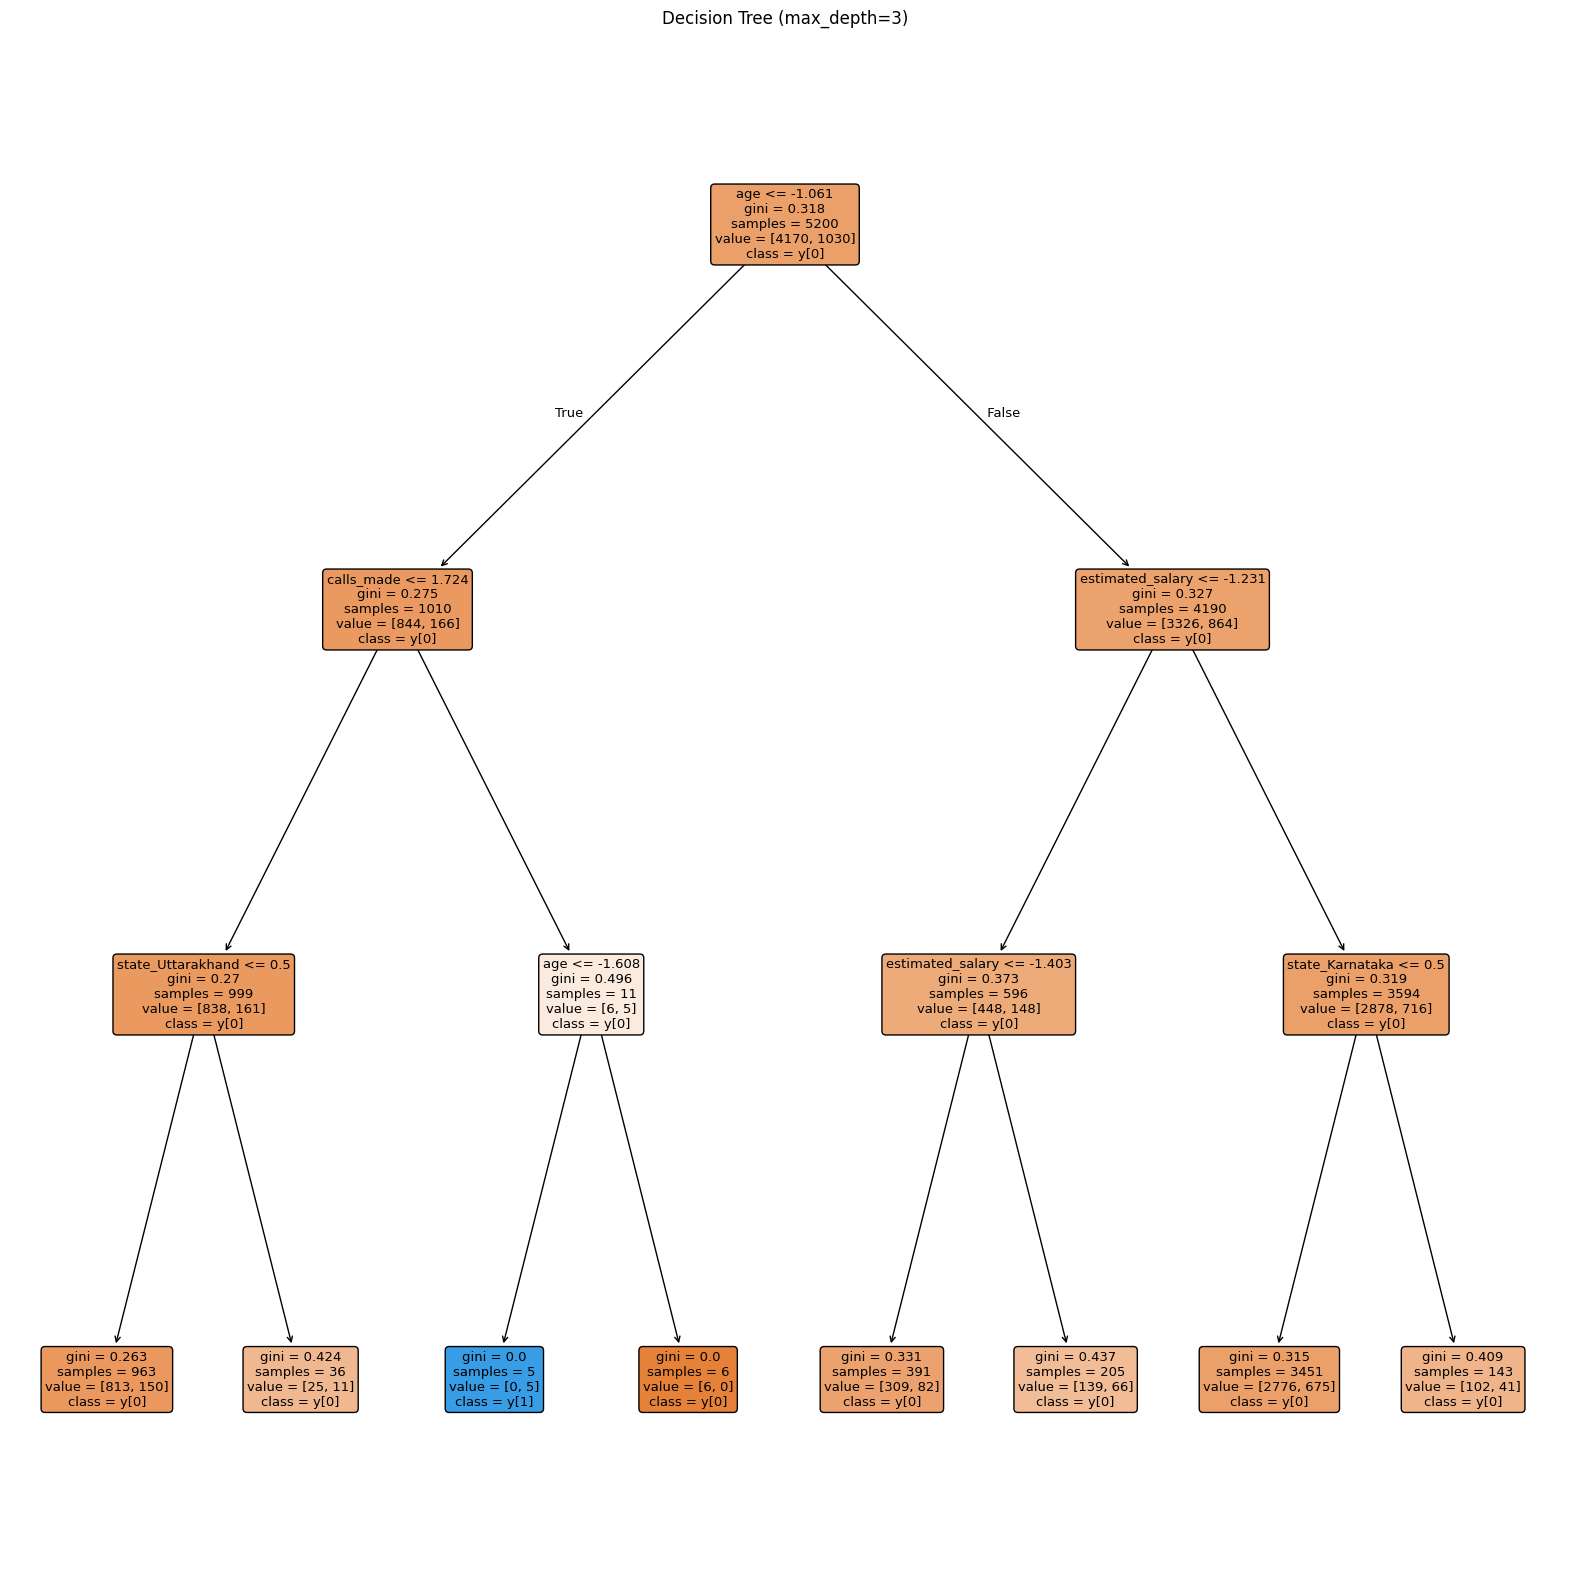

Depth:5 has accuray of: 0.7838461538461539


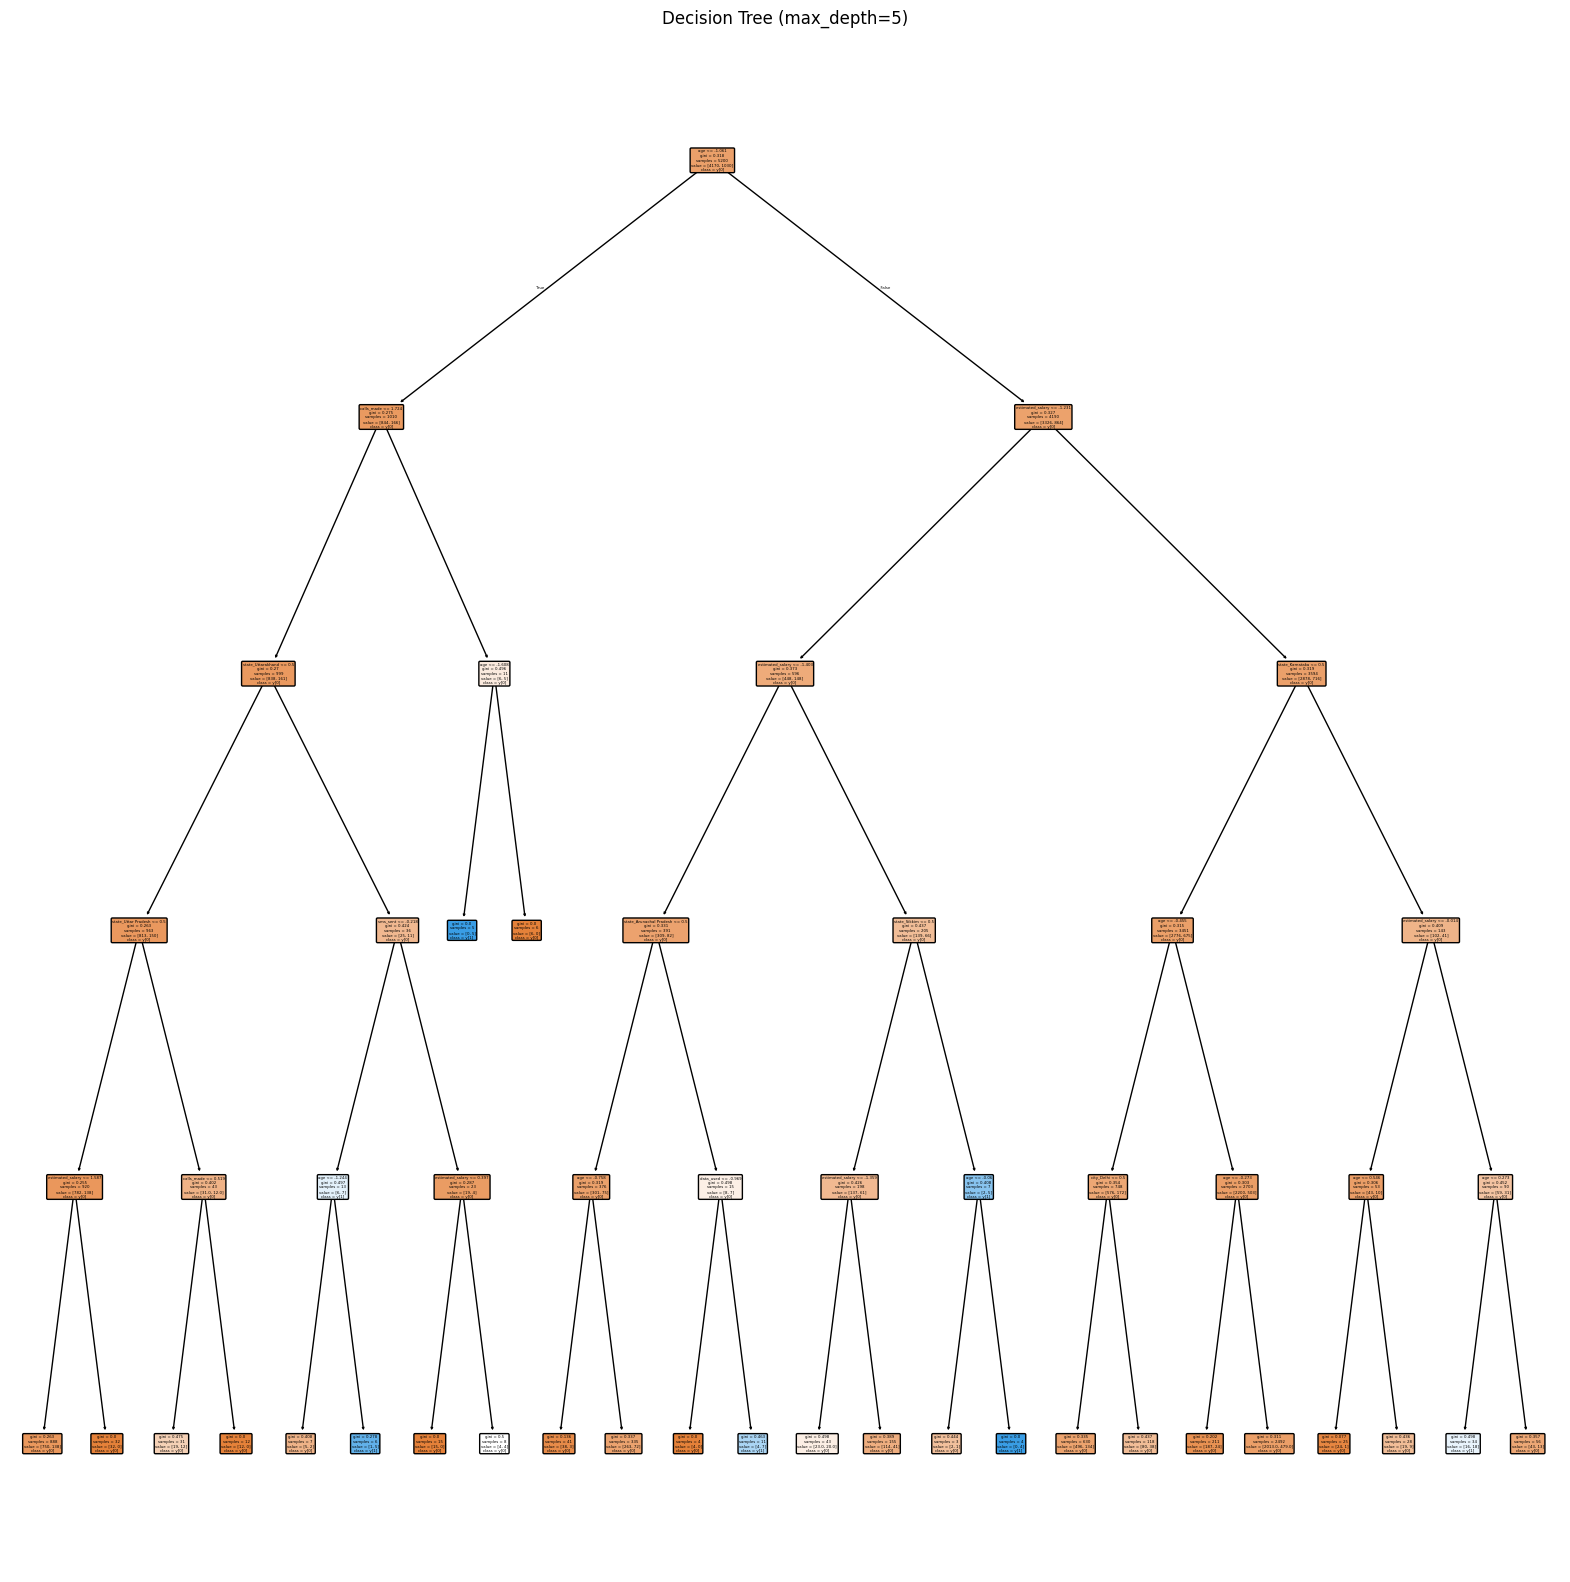

Depth:7 has accuray of: 0.7661538461538462


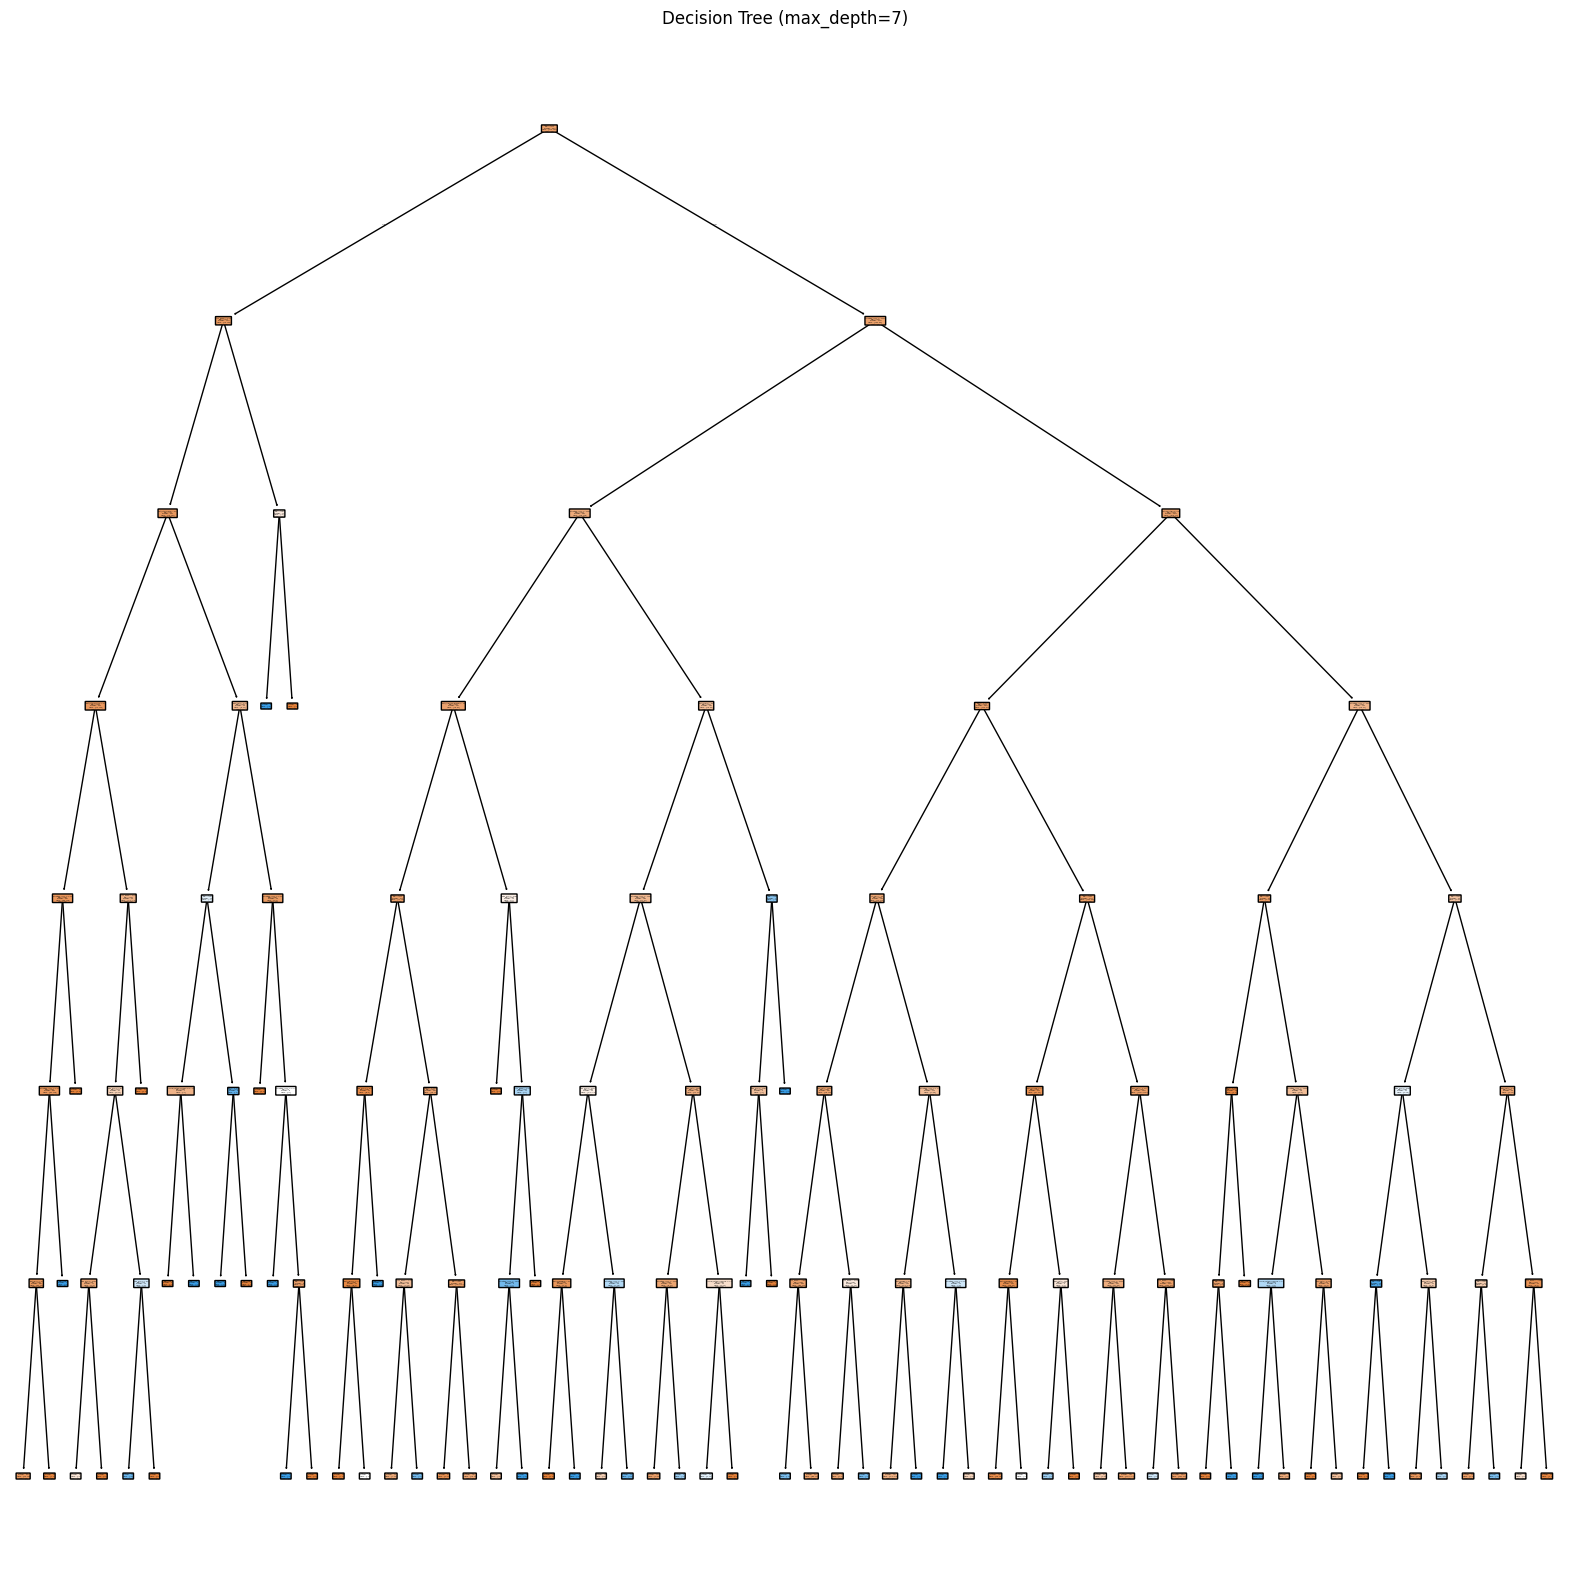

Depth:9 has accuray of: 0.7576923076923077


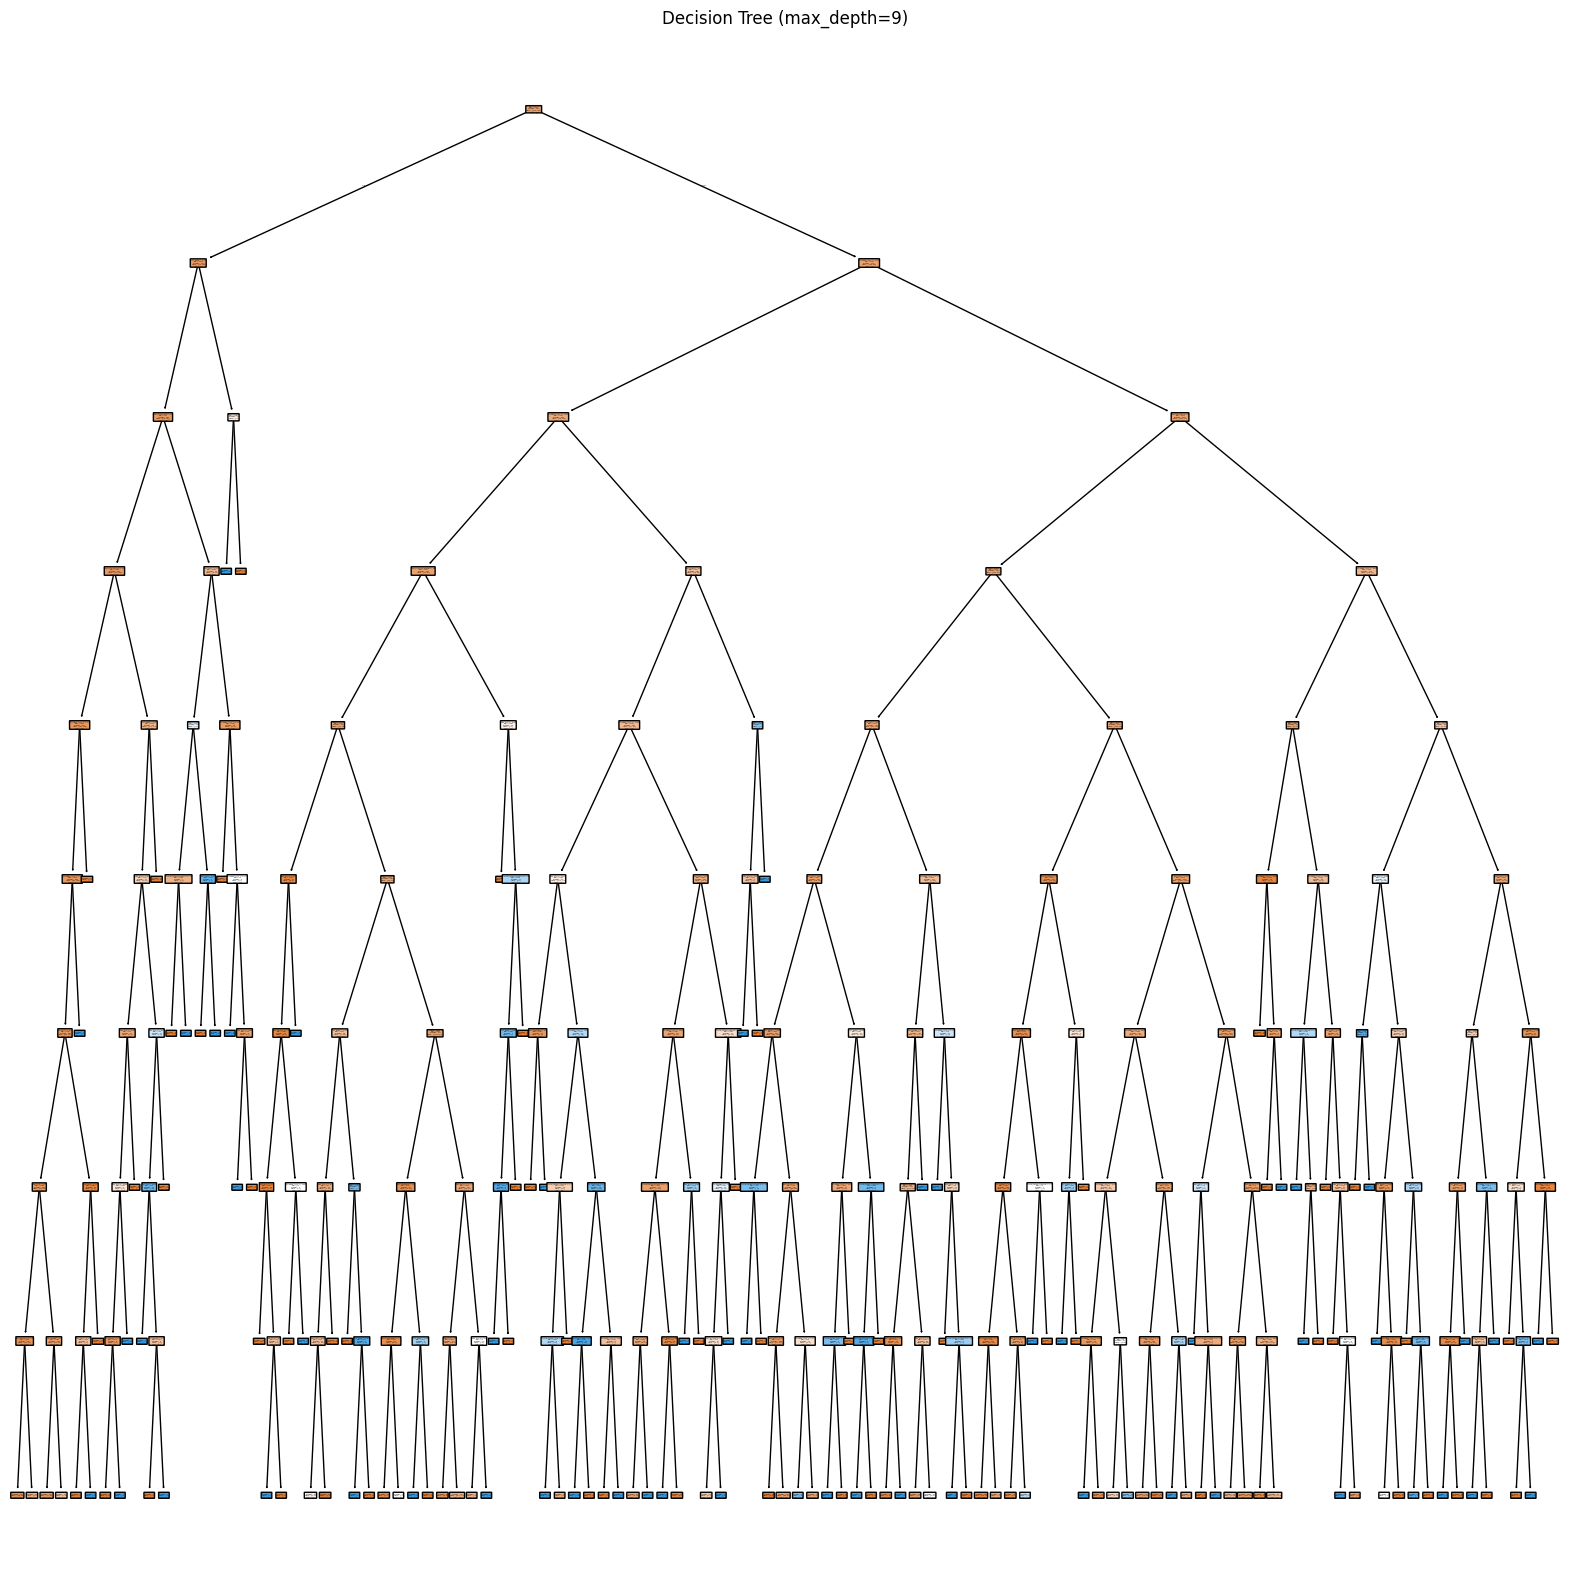

In [252]:
def decision_tree_ohe(max_depth, X_train_final_ohe, X_test_final_ohe):
    for i in max_depth:
        clf = DecisionTreeClassifier(max_depth=i)
        clf.fit(X_train_final_ohe, y_train)
        y_pred = clf.predict(X_test_final_ohe)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Depth:{i} has accuray of: {accuracy}")
        plt.figure(figsize=(20, 20))
        tree.plot_tree(clf, filled=True, feature_names=X_train_final_ohe.columns, class_names=True, rounded=True)
        plt.title(f"Decision Tree (max_depth={i})")
        plt.show()

decision_tree_ohe([3,5,7,9], X_train_final_ohe, X_test_final_ohe)

RANDOM FOREST

In [253]:
def random_forest_ohe(n_estimators, X_train_final_ohe, X_test_final_ohe):
    
    for i in n_estimators:
        clf = RandomForestClassifier(n_estimators=i, random_state=42)

        clf.fit(X_train_final_ohe, y_train)

        y_pred = clf.predict(X_test_final_ohe)
        accuracy = accuracy_score(y_test, y_pred)
        print(accuracy)

random_forest_ohe([10,20,30,40,60], X_train_final_ohe, X_test_final_ohe)

0.7746153846153846
0.7853846153846153
0.79
0.7892307692307692
0.7892307692307692


------

ORDINAL ENCODER

In [254]:
ordinal_columns = ['telecom_partner', 'city', 'gender', 'state']

ordinal_encoder = OrdinalEncoder()

X_train_ordinal = ordinal_encoder.fit_transform(X_train[ordinal_columns])
X_test_ordinal = ordinal_encoder.transform(X_test[ordinal_columns])

X_train_ordinal_df = pd.DataFrame(X_train_ordinal, columns=ordinal_columns)
X_test_ordinal_df = pd.DataFrame(X_test_ordinal, columns=ordinal_columns)

print(X_train_ordinal_df.head())


   telecom_partner  city  gender  state
0              3.0   1.0     0.0    3.0
1              1.0   1.0     1.0   20.0
2              2.0   1.0     0.0    8.0
3              0.0   1.0     1.0   20.0
4              2.0   3.0     0.0   12.0


In [255]:
X_train_final_ordinal = pd.concat([X_train_ordinal_df, X_train_scaled], axis=1)
X_train_final_ordinal.shape

(5200, 9)

In [256]:
X_test_final_ordinal = pd.concat([X_test_ordinal_df, X_test_scaled], axis=1)
X_test_final_ordinal.shape

(1300, 9)

In [257]:
scaled_col = ['age', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used']

DECISION TREE

In [ ]:
def decision_tree_ordinal(max_depth, X_train_final_ordinal, X_test_final_ordinal, columns):

    for i in max_depth:
        clf = DecisionTreeClassifier(max_depth=i, random_state=42)
        
        clf.fit(X_train_final_ordinal, y_train)
        
        y_pred = clf.predict(X_test_final_ordinal)
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Max Depth: {i} has accuracy : {accuracy}")
        
        importances = clf.feature_importances_
        
        feature_importances = pd.DataFrame(importances, index=columns, columns=["Importance"]).sort_values("Importance", ascending=False)
        
        print("\nFeature Importances for Depth:", i)
        print(feature_importances)
        
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances at Depth: {i}")
        plt.barh(feature_importances.index, feature_importances["Importance"], color='skyblue')
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()

decision_tree_ordinal([3,5,7,9], X_train_final_ordinal, X_test_final_ordinal,ordinal_columns+scaled_col)

In [272]:
def random_forest_ordinal(X_train_final_ordinal, X_test_final_ordinal):
    
        clf = RandomForestClassifier(random_state=42)

        clf.fit(X_train_final_ordinal, y_train)

        y_pred = clf.predict(X_test_final_ordinal)
        accuracy = accuracy_score(y_test, y_pred)
        print(accuracy)

random_forest_ordinal(X_train_final_ordinal, X_test_final_ordinal)

0.786923076923077


Testing the data after dropping useless features

In [ ]:
X_train_ordinal_drop = X_train_final_ordinal.drop(columns=['gender', 'city', 'telecom_partner'])
X_test_ordinal_drop = X_test_final_ordinal.drop(columns=['gender', 'city', 'telecom_partner'])
print(X_train_ordinal_drop.shape, X_test_ordinal_drop.shape)
decision_tree_ordinal([3,5,7,9], X_train_ordinal_drop, X_test_ordinal_drop,X_train_ordinal_drop.columns)
random_forest_ordinal(X_train_ordinal_drop, X_test_ordinal_drop)

FINAL ANALYSIS:
-------

-----------------

1. The main difference between One-hot encoding vs the ordinal encoding is the number of input features, with one-hot encoding we have almost 40 columns as we create dummy features, the acurracy is pretty similar but One-Hot encoding is slightly better.

        One-Hot :

                Decision Tree: 79%
                Random Forest: 79%

        Ordinal : 

                Decision Tree: 79%
                Random Forest: 78.6%


2. As I increased the depth of the Decision Tree, I noticed a drop in accuracy due to overfitting. Initially, with smaller depths, the model underfit, failing to capture important patterns. However, the optimal performance occurred when the depth was between 3 and 5, where the model balanced complexity and generalization. Beyond that, the model started to overfit, performing well on the training set but poorly on test data. Hence, the optimal depth for my model was in the 3-5 range.


        3-5 depth : 79%

        5 < depth : 76%


3. When I dropped features like city, gender, and provider, I observed a slight increase in accuracy. This suggests that these features were not as important for the model's decision-making process. Using the OrdinalEncoder, the model likely focused on more relevant features, improving its overall performance. The change highlights how some features can add noise rather than value, and removing them can enhance model accuracy.


------------

Based on my analysis, the most influential features in predicting customer churn were those directly related to customer behavior and service usage, such as the scaled features :estimated_salary	calls_made	sms_sent	data_used, and age. These features consistently had a higher impact on model performance compared to demographic factors like provider, city, state, and gender. By focusing on these key variables, we can better understand churn drivers and target strategies to retain customers more effectively.